<a href="https://colab.research.google.com/github/Wanxi-z/python-for-finance/blob/master/%E2%80%9CExercise_Partial_Solutions_2025_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**


To run this notebook, please proceed as follows:
- Use a Google Drive account and create a new folder called "Quantitative_Trading_and_Price_Impact_2025" in My Drive.
- Create a subfolder called "Data" and copy the two zip files "binSamples.zip" and "fillSamples.zip" to that subfolder.

To save changes in the notebook, go to File -> Save a copy in Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/My Drive/Quantitative_Trading_and_Price_Impact_2025/")

Mounted at /content/drive


In [2]:
import zipfile
import shutil
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
plt.style.use("ggplot")

In [3]:
year = "2019"
data_dir = "/content/drive/My Drive/Quantitative_Trading_and_Price_Impact_2025/Data/"
bin_sample_path = f"{data_dir}binSamples/"
fill_sample_path = f"{data_dir}fillSamples/"
result_path = f"{data_dir}inter_results/"
os.makedirs(result_path, exist_ok=True)

In [4]:
path_to_zip_file = f"{data_dir}binSamples.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [5]:
path_to_zip_file = f"{data_dir}fillSamples.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

### **Computing price volatility and ADV**

In [6]:
monthly_stock_info_dfs = []
for month_int in range(1, 13):
    sys.stdout.write(f"\rCurrent month being processed: {month_int}")
    sys.stdout.flush()
    month = '%02d' % month_int
    filename = "bin%s%s.csv" % (year, month)
    bin_sample_df = pd.read_csv(bin_sample_path+filename)

    monthly_traded_volume_df = bin_sample_df[["stock", "date", "trade", "time"]].pivot(index=["stock", "date"], columns=["time"])["trade"].fillna(0).astype(int)
    monthly_px_df = bin_sample_df[["stock", "date", "midEnd", "time"]].pivot(index=["stock", "date"], columns=["time"])["midEnd"].ffill(axis="columns").bfill(axis="columns")
    monthly_stock_info_dfs.append(pd.DataFrame({
        "px_vol" : monthly_px_df.pct_change(1, axis="columns").std(axis="columns"),
        "volume" : monthly_traded_volume_df.abs().sum(axis="columns"),
    }).reset_index())

stock_info_df = pd.concat(monthly_stock_info_dfs).reset_index(drop=True)

Current month being processed: 12

In [7]:
stock_info_df

,stock,date,px_vol,volume
0,A,2019-01-02,0.000383,217804
1,A,2019-01-03,0.000527,485020
2,A,2019-01-04,0.000366,244093
3,A,2019-01-07,0.000359,251175
4,A,2019-01-08,0.000364,181329
...,...,...,...,...
12397,ARE,2019-12-20,0.000225,57796
12398,ARE,2019-12-23,0.000112,45866
12399,ARE,2019-12-24,0.000135,17555
12400,ARE,2019-12-26,0.000138,24736


In [8]:
#Save the data for later use
filename = f"volume_px_vol_{year}.csv"
stock_info_df.to_csv(result_path+filename, index=False)

In [9]:
num_days_precompute = 20
stacked_info = stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(num_days_precompute).mean().shift(1)
scaling_df = pd.DataFrame({
    "px_vol" : stacked_info["px_vol"].unstack(),
    "volume" : stacked_info["volume"].unstack(),
}).reset_index()
filename = f"scaling_factors_{year}.csv"
scaling_df.to_csv(result_path+filename, index=False)
scaling_df[:40]

,stock,date,px_vol,volume
0,A,2019-01-02,NaN,NaN
1,A,2019-01-03,NaN,NaN
2,A,2019-01-04,NaN,NaN
3,A,2019-01-07,NaN,NaN
4,A,2019-01-08,NaN,NaN
5,A,2019-01-09,NaN,NaN
6,A,2019-01-10,NaN,NaN
7,A,2019-01-11,NaN,NaN
8,A,2019-01-14,NaN,NaN
9,A,2019-01-15,NaN,NaN


### **Computing intraday impact states**

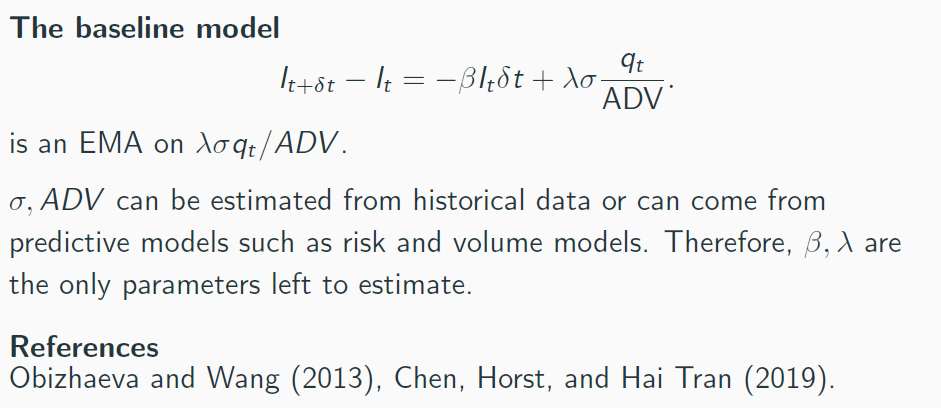

Setting $\delta t=1$ and rewriting the equation yields
$$
\frac{I_{t+1}}{\lambda}=\frac{(1-\beta)I_t}{\lambda}+\sigma\frac{q_t}{ADV},
$$
which in turn allows the iterative computation of $I_t/\lambda$ for $t=0,1,2,\ldots$.

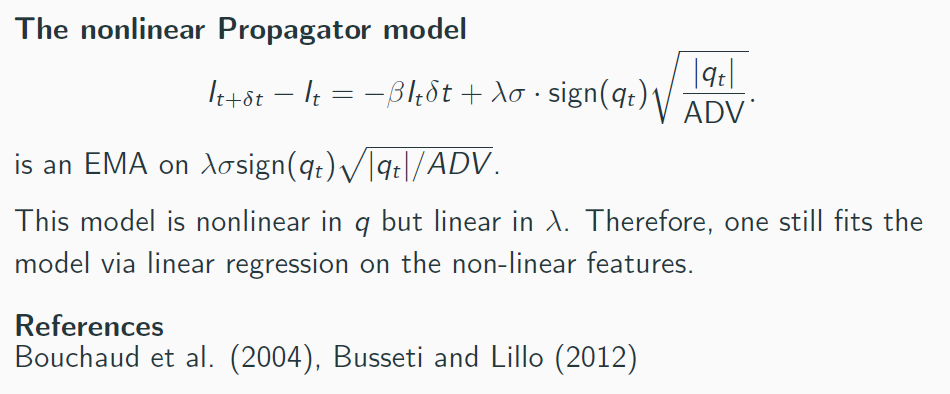

Setting $\delta t=1$ and rewriting the equation yields
$$
\frac{I_{t+1}}{\lambda}=\frac{(1-\beta)I_t}{\lambda}+\sigma\operatorname{sgn}(q_t)\sqrt{\frac{|q_t|}{ADV}},
$$
which in turn allows the iterative computation of $I_t/\lambda$ for $t=0,1,2,\ldots$.

In [10]:
month_int = 2
month = '%02d' % month_int
filename = "bin%s%s.csv" % (year, month)
bin_sample_df = pd.read_csv(bin_sample_path+filename)

traded_volume_df = bin_sample_df[["stock", "date", "trade", "time"]].pivot(index=["stock", "date"], columns=["time"])["trade"].fillna(0).astype(int)
px_df = bin_sample_df[["stock", "date", "midEnd", "time"]].pivot(index=["stock", "date"], columns=["time"])["midEnd"].ffill(axis="columns").bfill(axis="columns")

In [11]:
stock="AAPL"
date="2019-02-21"

px_df.loc[stock,date]

,AAPL
,2019-02-21
time,
09:30:00,171.780
09:30:10,171.670
09:30:20,171.600
09:30:30,171.830
09:30:40,171.760
...,...
15:59:20,171.000
15:59:30,171.045


In [12]:
def impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type):

    space_kernels = {
        "linear" : lambda x : x,
        "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
    }

    beta = np.log(2) / half_life
    decay_factor = np.exp(-beta * 10)
    pre_ewm = traded_volume_df.copy()
    pre_ewm = pre_ewm.divide(monthly_scaling_factor["volume"], axis="rows")
    pre_ewm = space_kernels[model_type](pre_ewm)
    pre_ewm = pre_ewm.multiply(monthly_scaling_factor["px_vol"], axis="rows")
    pre_ewm.iloc[:, 1:] /= (1 - decay_factor)
    cum_impact = cum_impact = pre_ewm.T.ewm(alpha=1-decay_factor, adjust=False).mean().T
    return cum_impact

In [13]:
monthly_scaling_factor = scaling_df.set_index(["stock", "date"]).loc[traded_volume_df.index]
half_life = 3600
model_type = "linear"
cum_impact = impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type)
cum_impact

time                  09:30:00      09:30:10      09:30:20      09:30:30  \
stock date                                                                 
A     2019-02-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-04  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-05  0.000000e+00  0.000000e+00 -1.517334e-09 -1.514415e-09   
      2019-02-06  1.512828e-07  1.509918e-07  1.507014e-07  1.504115e-07   
      2019-02-07  0.000000e+00  0.000000e+00  0.000000e+00 -1.461321e-07   
...                        ...           ...           ...           ...   
ARE   2019-02-22  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-25  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-26  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-27  0.000000e+00  0.000000e+00  2.985004e-07  4.978393e-07   
      2019-02-28  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

time                  09:30:40      09:30:50      09:31:00      09:31:10  \
stock date                                                                 
A     2019-02-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-04  0.000000e+00  0.000000e+00  0.000000e+00  2.989256e-07   
      2019-02-05 -1.511502e-09 -1.508595e-09 -1.505693e-09 -1.502797e-09   
      2019-02-06  1.501222e-07  1.498334e-07  1.495452e-07  1.492575e-07   
      2019-02-07 -1.458510e-07 -1.455705e-07 -1.452905e-07 -1.450110e-07   
...                        ...           ...           ...           ...   
ARE   2019-02-22  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-25  1.463981e-07  1.461165e-07  1.458355e-07  1.455549e-07   
      2019-02-26  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-27  4.968817e-07  4.959259e-07  4.949720e-07  4.940199e-07   
      2019-02-28  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

time                  09:31:20      09:31:30  ...  15:58:30  15:58:40  \
stock date                                    ...                       
A     2019-02-01  0.000000e+00  0.000000e+00  ... -0.000009 -0.000009   
      2019-02-04  2.983506e-07  2.977767e-07  ... -0.000013 -0.000013   
      2019-02-05 -1.499906e-09  1.367632e-08  ... -0.000007 -0.000007   
      2019-02-06  1.489704e-07  4.512496e-07  ... -0.000028 -0.000028   
      2019-02-07 -1.447321e-07 -1.444537e-07  ...  0.000002  0.000003   
...                        ...           ...  ...       ...       ...   
ARE   2019-02-22  0.000000e+00  0.000000e+00  ...  0.000002  0.000001   
      2019-02-25  1.452750e-07  1.449955e-07  ...  0.000005  0.000005   
      2019-02-26  0.000000e+00  0.000000e+00  ... -0.000034 -0.000034   
      2019-02-27  4.930696e-07  4.921211e-07  ... -0.000012 -0.000012   
      2019-02-28  0.000000e+00  0.000000e+00  ... -0.000016 -0.000017   

time              15:58:50  15:59:00  15:59:10      15:59:20      15:59:30  \
stock date                                                                   
A     2019-02-01 -0.000009 -0.000009 -0.000009 -9.033676e-06 -9.016299e-06   
      2019-02-04 -0.000013 -0.000012 -0.000014 -1.365145e-05 -1.407358e-05   
      2019-02-05 -0.000006 -0.000007 -0.000007 -6.747673e-06 -7.250587e-06   
      2019-02-06 -0.000028 -0.000028 -0.000029 -2.926432e-05 -3.309146e-05   
      2019-02-07  0.000004  0.000005  0.000005  5.814783e-06  5.657466e-06   
...                    ...       ...       ...           ...           ...   
ARE   2019-02-22  0.000001  0.000001  0.000001  9.870005e-07  9.851020e-07   
      2019-02-25  0.000005  0.000005  0.000005  4.559539e-06  3.572829e-06   
      2019-02-26 -0.000035 -0.000035 -0.000035 -3.600241e-05 -3.550770e-05   
      2019-02-27 -0.000013 -0.000016 -0.000015 -1.558698e-05 -1.583085e-05   
      2019-02-28 -0.000018 -0.000018 -0.000019 -1.852209e-05 -1.857740e-05   

time              15:59:40  15:59:50  16:00:00  
stock da

In [14]:
def impact_state_afs(traded_volume_df, monthly_scaling_factor, half_life, model_type):
    space_kernels = {
        "linear" : lambda x : x,
        "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
    }

    beta = np.log(2) / half_life
    decay_factor = np.exp(-beta * 10)

    # Step 1: volume-space linear impact
    pre_ewm = traded_volume_df.copy()
    pre_ewm = pre_ewm.divide(monthly_scaling_factor["volume"], axis="rows")
    pre_ewm = space_kernels[model_type](pre_ewm)  # always linear here
    pre_ewm = pre_ewm.multiply(monthly_scaling_factor["px_vol"], axis="rows")
    pre_ewm.iloc[:, 1:] /= (1 - decay_factor)
    J_t = pre_ewm.T.ewm(alpha=1 - decay_factor, adjust=False).mean().T

    # Step 2: nonlinear transformation
    I_t = np.sign(J_t) * np.sqrt(np.abs(J_t))
    return I_t


In [15]:
monthly_scaling_factor = scaling_df.set_index(["stock", "date"]).loc[traded_volume_df.index]
half_life = 3600
model_type = "linear"
cum_impact_afs = impact_state_afs(traded_volume_df, monthly_scaling_factor, half_life, model_type)
cum_impact_afs

time              09:30:00  09:30:10  09:30:20  09:30:30  09:30:40  09:30:50  \
stock date                                                                     
A     2019-02-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      2019-02-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      2019-02-05  0.000000  0.000000 -0.000039 -0.000039 -0.000039 -0.000039   
      2019-02-06  0.000389  0.000389  0.000388  0.000388  0.000387  0.000387   
      2019-02-07  0.000000  0.000000  0.000000 -0.000382 -0.000382 -0.000382   
...                    ...       ...       ...       ...       ...       ...   
ARE   2019-02-22  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      2019-02-25  0.000000  0.000000  0.000000  0.000000  0.000383  0.000382   
      2019-02-26  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      2019-02-27  0.000000  0.000000  0.000546  0.000706  0.000705  0.000704   
      2019-02-28  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

time              09:31:00  09:31:10  09:31:20  09:31:30  ...  15:58:30  \
stock date                                                ...             
A     2019-02-01  0.000000  0.000000  0.000000  0.000000  ... -0.003057   
      2019-02-04  0.000000  0.000547  0.000546  0.000546  ... -0.003589   
      2019-02-05 -0.000039 -0.000039 -0.000039  0.000117  ... -0.002668   
      2019-02-06  0.000387  0.000386  0.000386  0.000672  ... -0.005299   
      2019-02-07 -0.000381 -0.000381 -0.000380 -0.000380  ...  0.001285   
...                    ...       ...       ...       ...  ...       ...   
ARE   2019-02-22  0.000000  0.000000  0.000000  0.000000  ...  0.001503   
      2019-02-25  0.000382  0.000382  0.000381  0.000381  ...  0.002145   
      2019-02-26  0.000000  0.000000  0.000000  0.000000  ... -0.005792   
      2019-02-27  0.000704  0.000703  0.000702  0.000702  ... -0.003422   
      2019-02-28  0.000000  0.000000  0.000000  0.000000  ... -0.003941   

time              15:58:40  15:58:50  15:59:00  15:59:10  15:59:20  15:59:30  \
stock date                                                                     
A     2019-02-01 -0.003042 -0.003039 -0.003031 -0.003028 -0.003006 -0.003003   
      2019-02-04 -0.003627 -0.003649 -0.003498 -0.003777 -0.003695 -0.003751   
      2019-02-05 -0.002578 -0.002516 -0.002603 -0.002629 -0.002598 -0.002693   
      2019-02-06 -0.005277 -0.005272 -0.005264 -0.005373 -0.005410 -0.005753   
      2019-02-07  0.001620  0.001983  0.002155  0.002191  0.002411  0.002379   
...                    ...       ...       ...       ...       ...       ...   
ARE   2019-02-22  0.001101  0.001096  0.001216  0.001215  0.000993  0.000993   
      2019-02-25  0.002142  0.002300  0.002139  0.002137  0.002135  0.001890   
      2019-02-26 -0.005820 -0.005920 -0.005892 -0.005911 -0.006000 -0.005959   
      2019-02-27 -0.003506 -0.003624 -0.003978 -0.003934 -0.003948 -0.003979   
      2019-02-28 -0.004071 -0.004197 -0.004261 -0.004308 -0.004304 -0.004310   

time              15:59:40  15:59:50  16:00:00  
stock date                                      
A     2019-02-01 -0.002975 -0.002948 -0.002945  
      2019-02-04 -0.003772 -0.003748 -0.003745  
      2019-02-05 -0.002718 -0.002601 -0.002599  
      2019-02-06 -0.005707 -0.005763 -0.005758  
      2019-02-07  0.002438  0.002390  0.002387  
...                    ...       ...       ...  
ARE   2019-02-22  0.001030  0.001167  0.001166  
      2019-02-25  0.001869  0.001837  0.001835  
      2019-02-26 -0.005901 -0.005851 -0.005846  
      2019-02-27 -0.003978 -0.004150 -0.004146  
      2019-02-28 -0.004346 -0.004213 -0.004209  

[950 rows x 2341 columns]

###**Fitting price impact models**

In [16]:
#Load traded volume and prices as before
year = "2019"
traded_volume_dfs=[]
px_dfs=[]
for month_int in range(1, 5): #Change to 13 for the whole year
  sys.stdout.write(f"\rCurrent month being processed: {month_int}")
  sys.stdout.flush()
  month = '%02d' % month_int
  filename = "bin%s%s.csv" % (year, month)
  bin_sample_df = pd.read_csv(bin_sample_path+filename)
  traded_volume_df = bin_sample_df[["stock", "date", "trade", "time"]].pivot(index=["stock", "date"], columns="time", values="trade").fillna(0)
  px_df = bin_sample_df[["stock", "date", "midEnd", "time"]].pivot(index=["stock", "date"], columns=["time"])["midEnd"].ffill(axis="columns").bfill(axis="columns")
  traded_volume_dfs.append(traded_volume_df)
  px_dfs.append(px_df)
traded_volume_df = pd.concat(traded_volume_dfs, axis=0)
px_df=pd.concat(px_dfs, axis=0)

Current month being processed: 4

In [17]:
#Recover scaling factors (see Exercise 2a)
filename = f"volume_px_vol_{year}.csv"
scaling_df=pd.read_csv(result_path+filename)

In [18]:
#Redefine the impact state function (see Exercise 2b)
def impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type):

    space_kernels = {
        "linear" : lambda x : x,
        "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
    }

    beta = np.log(2) / half_life
    decay_factor = np.exp(-beta * 10)
    pre_ewm = traded_volume_df.copy()
    pre_ewm = pre_ewm.divide(monthly_scaling_factor["volume"], axis="rows")
    pre_ewm = space_kernels[model_type](pre_ewm)
    pre_ewm = pre_ewm.multiply(monthly_scaling_factor["px_vol"], axis="rows")
    pre_ewm.iloc[:, 1:] /= (1 - decay_factor)
    cum_impact = cum_impact = pre_ewm.T.ewm(alpha=1-decay_factor, adjust=False).mean().T
    return cum_impact

In [19]:
def impact_state_afs(traded_volume_df, monthly_scaling_factor, half_life, model_type):
    space_kernels = {
        "linear" : lambda x : x,
        "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
    }

    beta = np.log(2) / half_life
    decay_factor = np.exp(-beta * 10)

    # Step 1: volume-space linear impact
    pre_ewm = traded_volume_df.copy()
    pre_ewm = pre_ewm.divide(monthly_scaling_factor["volume"], axis="rows")
    pre_ewm = space_kernels[model_type](pre_ewm)  # always linear here
    pre_ewm = pre_ewm.multiply(monthly_scaling_factor["px_vol"], axis="rows")
    pre_ewm.iloc[:, 1:] /= (1 - decay_factor)
    J_t = pre_ewm.T.ewm(alpha=1 - decay_factor, adjust=False).mean().T

    # Step 2: nonlinear transformation
    I_t = np.sign(J_t) * np.sqrt(np.abs(J_t))
    return I_t

In [20]:
# Precompute regression statistics
# Here, explanation_horizon_periods are the number of 10s-periods for the explanation horizon (e.g. 5min corresponds to 30 periods)

def impact_regression_statistics(cum_impact, explanation_horizon_periods, px_df):
    impact_changes = cum_impact.diff(explanation_horizon_periods, axis="columns").T.unstack()
    reg_stat_df = impact_changes.reset_index().rename({"level_2":"time", 0:"x"}, axis="columns")
    returns = px_df.pct_change(explanation_horizon_periods, axis="columns").T.unstack().reset_index().rename({"level_2":"time", 0:"y"}, axis="columns")
    reg_stat_df = reg_stat_df.loc[reg_stat_df["time"] >= "10:00:00"].dropna(axis=0).copy()
    reg_stat_df["y"] = returns["y"]
    reg_stat_df["xy"] = reg_stat_df["x"] * reg_stat_df["y"]
    reg_stat_df["xx"] = reg_stat_df["x"] * reg_stat_df["x"]
    reg_stat_df["yy"] = reg_stat_df["y"] * reg_stat_df["y"]
    reg_stat_df["count"] = 1
    return reg_stat_df

In [21]:
half_life = 3600 #half-life in seconds
explanation_horizon_periods = 6

beta = np.log(2) / half_life
decay_factor = np.exp(-beta * 10)
monthly_scaling_factor = scaling_df.set_index(["stock", "date"]).loc[traded_volume_df.index]

model_type = "linear"
cum_impact = impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type)
reg_stat_df = impact_regression_statistics(cum_impact, explanation_horizon_periods, px_df)
linear_summary_df = reg_stat_df.groupby(["stock", "date"]).sum().reset_index().drop(columns=["time"])
linear_summary_df = linear_summary_df.loc[linear_summary_df["y"] >= 0.0001].copy()
linear_summary_df["date"] = pd.to_datetime(linear_summary_df["date"])
filename = f"inter_results_{model_type}_{year}.csv"
linear_summary_df.to_csv(result_path+filename, index=False)

model_type = "sqrt"
cum_impact = impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type)
reg_stat_df = impact_regression_statistics(cum_impact, explanation_horizon_periods, px_df)
sqrt_summary_df = reg_stat_df.groupby(["stock", "date"]).sum().reset_index().drop(columns=["time"])
sqrt_summary_df = sqrt_summary_df.loc[sqrt_summary_df["y"] >= 0.0001].copy()
sqrt_summary_df["date"] = pd.to_datetime(sqrt_summary_df["date"])
filename = f"inter_results_{model_type}_{year}.csv"
sqrt_summary_df.to_csv(result_path+filename, index=False)

model_type = "linear"
cum_impact = impact_state_afs(traded_volume_df, monthly_scaling_factor, half_life, model_type)
reg_stat_df = impact_regression_statistics(cum_impact, explanation_horizon_periods, px_df)
afs_summary_df = reg_stat_df.groupby(["stock", "date"]).sum().reset_index().drop(columns=["time"])
afs_summary_df = afs_summary_df.loc[afs_summary_df["y"] >= 0.0001].copy()
afs_summary_df["date"] = pd.to_datetime(afs_summary_df["date"])
filename = f"inter_results_afs_{year}.csv"
afs_summary_df.to_csv(result_path + filename, index=False)


In [22]:
linear_summary_df

,stock,date,x,y,xy,xx,yy,count
2,A,2019-01-04,-0.000029,0.049112,4.691245e-07,1.022926e-09,0.001220,2161
3,A,2019-01-07,-0.000038,0.091259,3.877372e-07,1.327259e-09,0.000915,2161
4,A,2019-01-08,0.000003,0.012770,3.438717e-07,1.422903e-09,0.001186,2161
6,A,2019-01-10,0.000002,0.102493,3.502556e-07,8.731926e-10,0.000723,2161
7,A,2019-01-11,0.000169,0.076132,3.441060e-07,1.645929e-09,0.000421,2161
...,...,...,...,...,...,...,...,...
4092,ARE,2019-04-18,0.000011,0.072300,3.482356e-07,1.592010e-09,0.000606,2161
4094,ARE,2019-04-23,0.000015,0.078270,3.813784e-07,1.128968e-09,0.000438,2161
4095,ARE,2019-04-24,-0.000016,0.045478,2.672843e-07,8.804894e-10,0.000269,2161
4096,ARE,2019-04-25,-0.000158,0.008233,2.878051e-07,1.127084e-09,0.000379,2161


In [23]:
def regression_result(daily_stock_reg_info_df, in_sample_month):
    in_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month]
    out_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month + 1]
    in_sample_summary_df = in_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()
    out_sample_summary_df = out_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()
    in_sample_summary_df.columns = "is_" + in_sample_summary_df.columns
    out_sample_summary_df.columns = "oos_" + out_sample_summary_df.columns

    summary_df = pd.merge(in_sample_summary_df, out_sample_summary_df, left_index=True, right_index=True, how="inner")
    summary_df["beta_estimate"] = (summary_df["is_xy"] - summary_df["is_xx"] * summary_df["is_yy"] / summary_df["is_count"]) / (summary_df["is_xx"] - summary_df["is_x"] ** 2 / summary_df["is_count"])
    summary_df["alpha_estimate"] = summary_df["is_y"] / summary_df["is_count"] - summary_df["beta_estimate"] * summary_df["is_x"] / summary_df["is_count"]
    summary_df["is_sse"] = summary_df["is_yy"] - summary_df["is_y"] ** 2 / summary_df["is_count"]
    summary_df["is_mse"] = summary_df["is_yy"] - 2 * summary_df["beta_estimate"] * summary_df["is_xy"] - 2 * summary_df["alpha_estimate"] * summary_df["is_y"] + 2 * summary_df["alpha_estimate"] * summary_df["beta_estimate"] * summary_df["is_x"] + summary_df["beta_estimate"] ** 2 * summary_df["is_xx"] + summary_df["alpha_estimate"] ** 2 * summary_df["is_count"]
    summary_df["is_rsq"] = 1 - summary_df["is_mse"] / summary_df["is_sse"]
    summary_df["oos_sse"] = summary_df["oos_yy"] - summary_df["oos_y"] ** 2 / summary_df["oos_count"]
    summary_df["oos_mse"] = summary_df["oos_yy"] - 2 * summary_df["beta_estimate"] * summary_df["oos_xy"] - 2 * summary_df["alpha_estimate"] * summary_df["oos_y"] + 2 * summary_df["alpha_estimate"] * summary_df["beta_estimate"] * summary_df["oos_x"] + summary_df["beta_estimate"] ** 2 * summary_df["oos_xx"] + summary_df["alpha_estimate"] ** 2 * summary_df["oos_count"]
    summary_df["oos_rsq"] = 1 - summary_df["oos_mse"] / summary_df["oos_sse"]
    return summary_df

In [24]:
in_sample_month = 2
linear_r2_df = regression_result(linear_summary_df, in_sample_month)
linear_r2_df = linear_r2_df[["beta_estimate", "alpha_estimate", "is_rsq", "oos_rsq"]].reset_index()
filename = f"regression_linear_{year}.csv"
linear_r2_df.to_csv(result_path+filename, index=False)

mean_is=linear_r2_df["is_rsq"].mean().round(5)
mean_oos=linear_r2_df["oos_rsq"].mean().round(5)
print(f"Linear model mean IS R^2 for Month {in_sample_month}: {mean_is}")
print(f"Linear model mean OOS R^2 for Months {in_sample_month}/{in_sample_month+1}: {mean_oos}")
linear_r2_df[:20]

Linear model mean IS R^2 for Month 2: 0.19496
Linear model mean OOS R^2 for Months 2/3: 0.17638


,stock,beta_estimate,alpha_estimate,is_rsq,oos_rsq
0,A,378.237876,0.000014,0.228820,0.170189
1,AAL,368.398264,0.000006,0.217599,0.223857
2,AAP,340.242639,0.000044,0.202209,0.203510
3,AAPL,434.078594,0.000013,0.255271,0.240376
4,ABBV,334.609486,0.000021,0.161713,0.175173
5,ABC,355.153668,0.000020,0.227198,0.220539
6,ABMD,214.818170,0.000033,0.196094,0.185643
7,ABT,407.043787,0.000014,0.172626,0.149470
8,ACN,378.335515,0.000010,0.179074,0.169685
9,ADBE,396.606037,0.000008,0.170156,0.124629


In [25]:
in_sample_month = 2
sqrt_r2_df = regression_result(sqrt_summary_df, in_sample_month)
sqrt_r2_df = sqrt_r2_df[["beta_estimate", "alpha_estimate", "is_rsq", "oos_rsq"]].reset_index()
filename = f"regression_sqrt_{year}.csv"
sqrt_r2_df.to_csv(result_path+filename, index=False)

mean_is=sqrt_r2_df["is_rsq"].mean().round(5)
mean_oos=sqrt_r2_df["oos_rsq"].mean().round(5)
print(f"Square-root model mean IS R^2 for Month {in_sample_month}: {mean_is}")
print(f"Square-root model mean OOS R^2 for Months {in_sample_month}/{in_sample_month+1}: {mean_oos}")
sqrt_r2_df[:20]

Square-root model mean IS R^2 for Month 2: 0.28156
Square-root model mean OOS R^2 for Months 2/3: 0.27498


,stock,beta_estimate,alpha_estimate,is_rsq,oos_rsq
0,A,20.473482,0.000014,0.289058,0.297821
1,AAL,22.381847,0.000007,0.321603,0.372842
2,AAP,21.537473,0.000041,0.312329,0.290847
3,AAPL,23.659837,0.000018,0.365194,0.369500
4,ABBV,17.606114,0.000020,0.228856,0.233462
5,ABC,21.365367,0.000019,0.303433,0.287961
6,ABMD,20.009096,0.000026,0.282115,0.274954
7,ABT,19.316198,0.000015,0.213286,0.204121
8,ACN,18.986442,0.000010,0.215249,0.227926
9,ADBE,21.858468,0.000005,0.267853,0.242272


In [26]:
in_sample_month = 2
afs_r2_df = regression_result(afs_summary_df, in_sample_month)
afs_r2_df = afs_r2_df[["beta_estimate", "alpha_estimate", "is_rsq", "oos_rsq"]].reset_index()
filename = f"regression_afs_{year}.csv"
afs_r2_df.to_csv(result_path + filename, index=False)

mean_is = afs_r2_df["is_rsq"].mean().round(5)
mean_oos = afs_r2_df["oos_rsq"].mean().round(5)
print(f"AFS model mean IS R^2 for Month {in_sample_month}: {mean_is}")
print(f"AFS model mean OOS R^2 for Months {in_sample_month}/{in_sample_month+1}: {mean_oos}")
afs_r2_df[:20]


AFS model mean IS R^2 for Month 2: 0.12704
AFS model mean OOS R^2 for Months 2/3: 0.11281


,stock,beta_estimate,alpha_estimate,is_rsq,oos_rsq
0,A,0.753973,0.000012,0.142512,0.168646
1,AAL,1.501199,0.000006,0.134477,0.131485
2,AAP,0.777979,0.000036,0.126611,0.161556
3,AAPL,1.079330,0.000013,0.183208,0.139628
4,ABBV,0.654439,0.000021,0.090359,0.112676
5,ABC,0.897896,0.000021,0.121814,0.112625
6,ABMD,0.674449,0.000034,0.119343,0.123854
7,ABT,0.674681,0.000015,0.099515,0.104194
8,ACN,0.579686,0.000009,0.093713,0.098851
9,ADBE,0.900095,0.000011,0.120620,0.097871


###**Implementing a backtest function**

In [27]:
kernels = {
    "linear": lambda x: x,
    "sqrt": lambda x: np.sign(x) * np.sqrt(np.abs(x)),
    "afs": "afs",
}

def impact_resultant_prices(trades, prices, decay, impact_coef, kernel, price_vol, ADV):
    trades_copy = trades.copy()

    if kernel == "afs":
        # Step 1: compute linear J_t via EMA
        pre_ewm = trades_copy / ADV
        pre_ewm[1:] /= (1 - decay)
        J_t = pre_ewm.ewm(alpha=1 - decay, adjust=False).mean()
        J_t *= price_vol  # scale by volatility

        # Step 2: AFS nonlinear transform
        cum_impacts = np.sign(J_t) * np.sqrt(np.abs(J_t))
        cum_impacts *= impact_coef

    else:
        trades_copy = kernel(trades_copy)
        trades_copy[1:] /= (1 - decay)
        cum_impacts = trades_copy.ewm(alpha=1 - decay, adjust=False).mean()
        cum_impacts *= price_vol / kernel(ADV)
        cum_impacts *= impact_coef

    # Add impact to cumulative returns
    cum_returns = prices / prices.iloc[0] - 1
    cum_returns += cum_impacts
    return prices.iloc[0] * (cum_returns + 1)

###**Applying the backtest function**

In [28]:
def impact_adjusted_prices(trades, prices, decay, impact_coef, kernel, price_vol, ADV):
    inverse_trades = trades.copy() * -1
    return impact_resultant_prices(inverse_trades, prices, decay, impact_coef, kernel, price_vol, ADV)

In [29]:
#Recover previous resuls
month_int = 2
month = '%02d' % month_int
filename = "bin%s%s.csv" % (year, month)
bin_sample_df = pd.read_csv(bin_sample_path+filename)
px_df = bin_sample_df[["stock", "date", "midEnd", "time"]].pivot(index=["stock", "date"], columns="time", values="midEnd").ffill(axis="columns").bfill(axis="columns")
traded_volume_df = bin_sample_df[["stock", "date", "trade", "time"]].pivot(index=["stock", "date"], columns="time", values="trade").fillna(0)

model_type = "linear"
filename = f"regression_{model_type}_{year}.csv"
linear_regression_res_df = pd.read_csv(result_path+filename)
linear_impact_coef_df = linear_regression_res_df[["stock", "beta_estimate"]]
model_type = "sqrt"
filename = f"regression_{model_type}_{year}.csv"
sqrt_regression_res_df = pd.read_csv(result_path+filename)
sqrt_impact_coef_df = sqrt_regression_res_df[["stock", "beta_estimate"]]
model_type = "afs"
filename = f"regression_{model_type}_{year}.csv"
afs_regression_res_df = pd.read_csv(result_path+filename)
afs_impact_coef_df = afs_regression_res_df[["stock", "beta_estimate"]]
filename = f"volume_px_vol_{year}.csv"
scaling_df = pd.read_csv(result_path+filename, index_col=[0,1])

In [30]:
stock = "AAPL"
date = "2019-02-21"
half_life = 3600

trades = traded_volume_df.loc[stock, date]
prices = px_df.loc[stock, date]
price_vol, ADV = scaling_df.loc[stock, date]
linear_impact_coef = linear_impact_coef_df.loc[linear_impact_coef_df["stock"]==stock, "beta_estimate"].iloc[0]
sqrt_impact_coef = sqrt_impact_coef_df.loc[sqrt_impact_coef_df["stock"]==stock, "beta_estimate"].iloc[0]
afs_impact_coef = afs_r2_df.loc[afs_r2_df["stock"] == stock, "beta_estimate"].iloc[0]
beta = np.log(2) / half_life
decay = np.exp(-beta * 10)

adjusted_prices_linear=impact_adjusted_prices(trades, prices, decay, linear_impact_coef, kernels["linear"], price_vol, ADV)
adjusted_prices_sqrt=impact_adjusted_prices(trades, prices, decay, sqrt_impact_coef, kernels["sqrt"], price_vol, ADV)
adjusted_prices_afs = impact_adjusted_prices(trades, prices, decay, afs_impact_coef, kernels["afs"], price_vol, ADV)

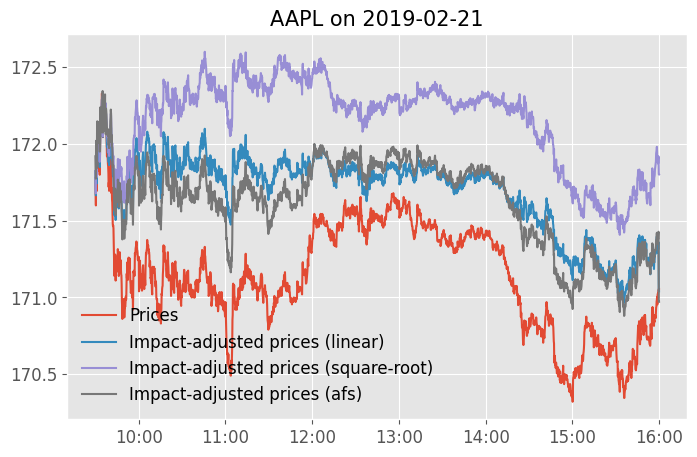

In [31]:
times = pd.to_datetime(date) + pd.to_timedelta(prices.index)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)
ax.plot(times, prices.values, label="Prices")
ax.plot(times, adjusted_prices_linear.values, label="Impact-adjusted prices (linear)")
ax.plot(times, adjusted_prices_sqrt.values, label="Impact-adjusted prices (square-root)")
ax.plot(times, adjusted_prices_afs.values, label="Impact-adjusted prices (afs)")
ax.legend(fontsize=12, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title(f"{stock} on {date}", fontsize=15)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.show()

In [32]:
def twap_strategy(prices, ADV, total_volume_fraction, decay, impact_coef, kernel, price_vol):
    n_steps = len(prices)
    trade_volume = (total_volume_fraction * ADV) / n_steps
    twap_trades = pd.Series(np.full(n_steps, trade_volume), index=prices.index)
    impacted_prices = impact_resultant_prices(twap_trades, prices, decay, impact_coef, kernel, price_vol, ADV)
    trade_size_pct = (twap_trades / ADV) * 100
    impact = impacted_prices - prices
    cum_avg_buy = impacted_prices.expanding().mean()
    pnl1_pct = (impacted_prices / cum_avg_buy - 1) * 100
    pnl2_pct = (prices / cum_avg_buy - 1) * 100

    return impacted_prices, trade_size_pct, impact, pnl1_pct, pnl2_pct

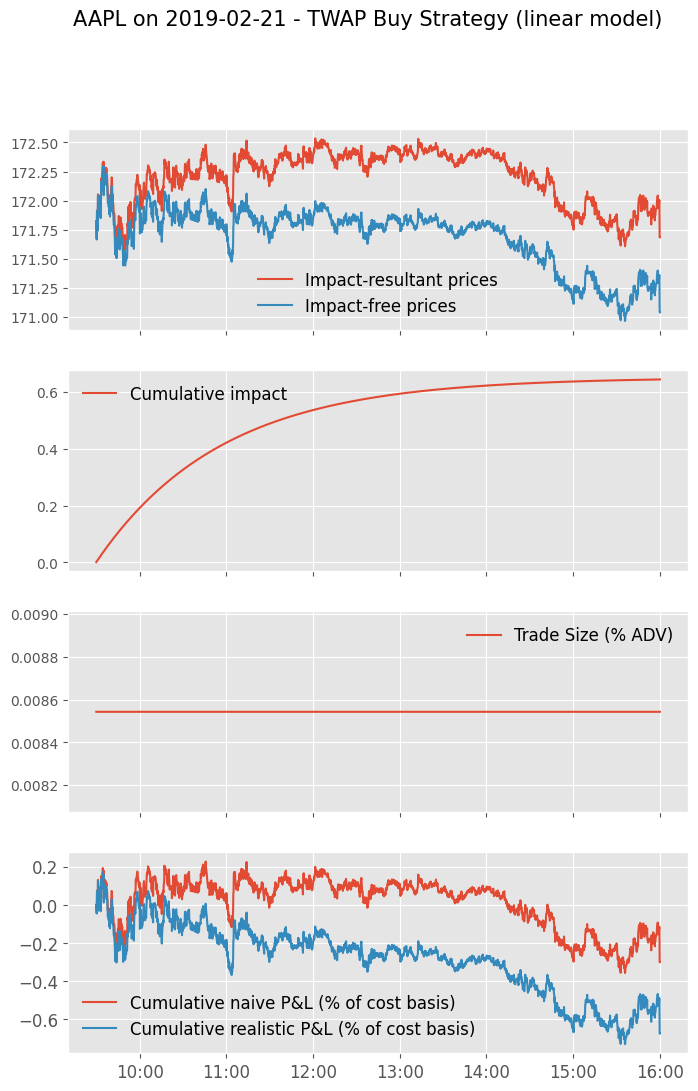

In [33]:
impacted_prices_twap, trade_size_series, impact, pnl1_series, pnl2_series = twap_strategy(adjusted_prices_linear, ADV, 0.2, decay, linear_impact_coef, kernels["linear"], price_vol)

times = pd.to_datetime(date) + pd.to_timedelta(prices.index)
fig, axs = plt.subplots(4, 1, figsize=(8,12), sharex=True)
axs[0].plot(times, impacted_prices_twap.values, label="Impact-resultant prices")
axs[0].plot(times, adjusted_prices_linear.values, label="Impact-free prices")
axs[0].legend(fontsize=12, frameon=False)
axs[1].plot(times, impact.values, label="Cumulative impact")
axs[1].legend(fontsize=12, frameon=False)
axs[2].plot(times, trade_size_series.values, label="Trade Size (% ADV)")
axs[2].legend(fontsize=12, frameon=False)
axs[3].plot(times, pnl1_series.values, label="Cumulative naive P&L (% of cost basis)")
axs[3].plot(times, pnl2_series.values, label="Cumulative realistic P&L (% of cost basis)")
axs[3].legend(fontsize=12, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.suptitle(f"{stock} on {date} - TWAP Buy Strategy (linear model)", fontsize=15)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.show()

In [34]:
afs_impact_coef = afs_r2_df.loc[afs_r2_df["stock"] == stock, "beta_estimate"].iloc[0]

twap_impacted_prices_afs, twap_trade_size_pct_afs, twap_impact_afs, twap_pnl1_afs, twap_pnl2_afs = twap_strategy(
    adjusted_prices_afs,
    ADV,
    total_volume_fraction=0.2,
    decay=decay,
    impact_coef=afs_impact_coef,
    kernel=kernels["afs"],
    price_vol=price_vol
)

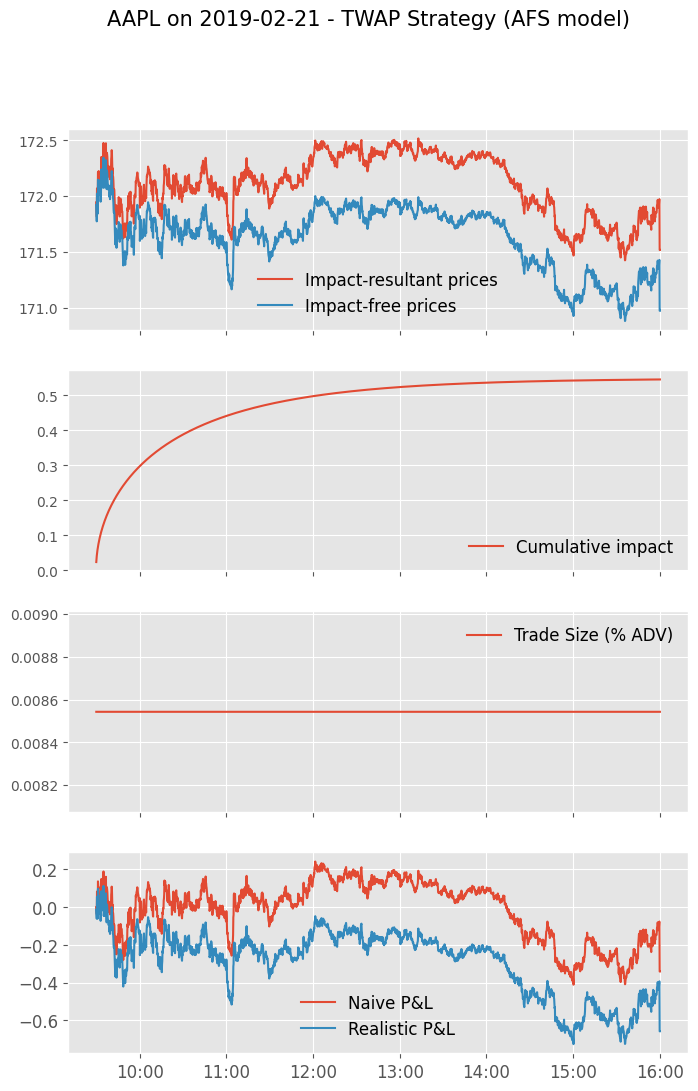

In [35]:
fig, axs = plt.subplots(4, 1, figsize=(8,12), sharex=True)
axs[0].plot(times, twap_impacted_prices_afs.values, label="Impact-resultant prices")
axs[0].plot(times, adjusted_prices_afs.values, label="Impact-free prices")
axs[0].legend(fontsize=12, frameon=False)
axs[1].plot(times, twap_impact_afs.values, label="Cumulative impact")
axs[1].legend(fontsize=12, frameon=False)
axs[2].plot(times, twap_trade_size_pct_afs.values, label="Trade Size (% ADV)")
axs[2].legend(fontsize=12, frameon=False)
axs[3].plot(times, twap_pnl1_afs.values, label="Naive P&L")
axs[3].plot(times, twap_pnl2_afs.values, label="Realistic P&L")
axs[3].legend(fontsize=12, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.suptitle(f"{stock} on {date} - TWAP Strategy (AFS model)", fontsize=15)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.show()

In [36]:
def vwap_strategy(prices, public_volume, ADV, total_volume_fraction, decay, impact_coef, kernel, price_vol):
    my_trades = total_volume_fraction * public_volume.abs()
    impacted_prices = impact_resultant_prices(my_trades, prices, decay, impact_coef, kernel, price_vol, ADV)
    trade_size_pct = (my_trades / ADV) * 100
    impact = impacted_prices - prices
    cum_avg_buy = impacted_prices.expanding().mean()
    pnl1_pct = (impacted_prices / cum_avg_buy - 1) * 100
    pnl2_pct = (prices / cum_avg_buy - 1) * 100

    return impacted_prices, trade_size_pct, impact, pnl1_pct, pnl2_pct

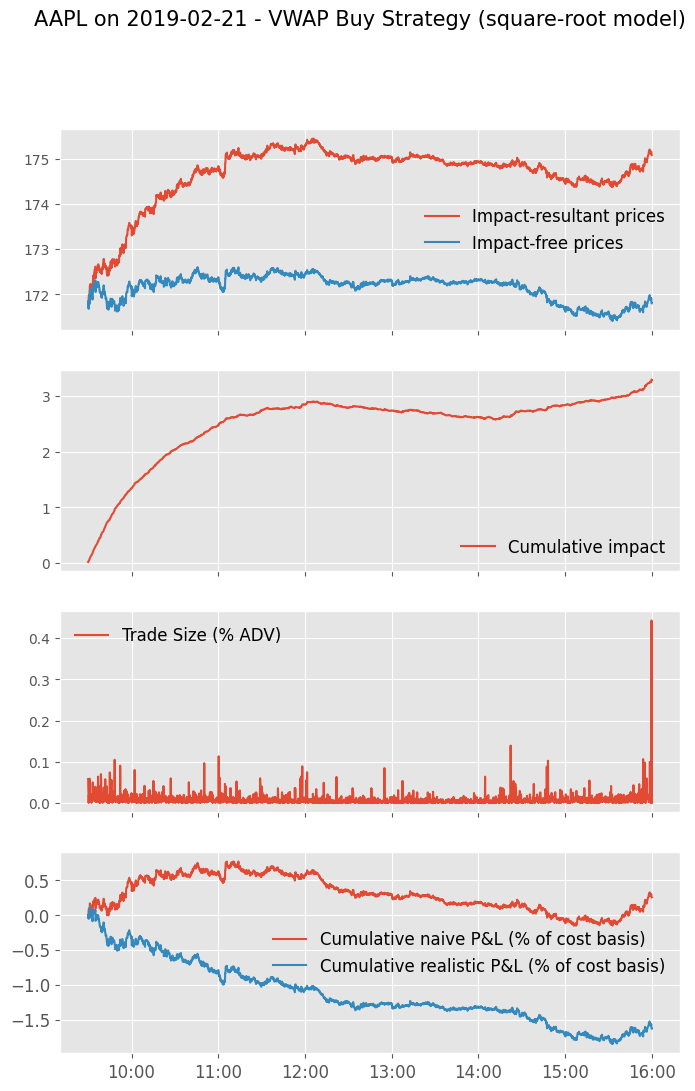

In [37]:
vwap_impacted_prices, vwap_trade_size_pct, vwap_impact, vwap_pnl1_pct, vwap_pnl2_pct  = vwap_strategy(adjusted_prices_sqrt, traded_volume_df.loc[stock, date], ADV, 0.2, decay, sqrt_impact_coef, kernels["sqrt"], price_vol)

times = pd.to_datetime(date) + pd.to_timedelta(prices.index)
fig, axs = plt.subplots(4, 1, figsize=(8,12), sharex=True)
axs[0].plot(times, vwap_impacted_prices.values, label="Impact-resultant prices")
axs[0].plot(times, adjusted_prices_sqrt.values, label="Impact-free prices")
axs[0].legend(fontsize=12, frameon=False)
axs[1].plot(times, vwap_impact.values, label="Cumulative impact")
axs[1].legend(fontsize=12, frameon=False)
axs[2].plot(times, vwap_trade_size_pct.values, label="Trade Size (% ADV)")
axs[2].legend(fontsize=12, frameon=False)
axs[3].plot(times, vwap_pnl1_pct.values, label="Cumulative naive P&L (% of cost basis)")
axs[3].plot(times, vwap_pnl2_pct.values, label="Cumulative realistic P&L (% of cost basis)")
axs[3].legend(fontsize=12, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.suptitle(f"{stock} on {date} - VWAP Buy Strategy (square-root model)", fontsize=15)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.show()

In [38]:
vwap_impacted_prices_afs, vwap_trade_size_pct_afs, vwap_impact_afs, vwap_pnl1_afs, vwap_pnl2_afs = vwap_strategy(
    adjusted_prices_afs,
    traded_volume_df.loc[stock, date],
    ADV,
    total_volume_fraction=0.2,
    decay=decay,
    impact_coef=afs_impact_coef,
    kernel=kernels["afs"],
    price_vol=price_vol
)


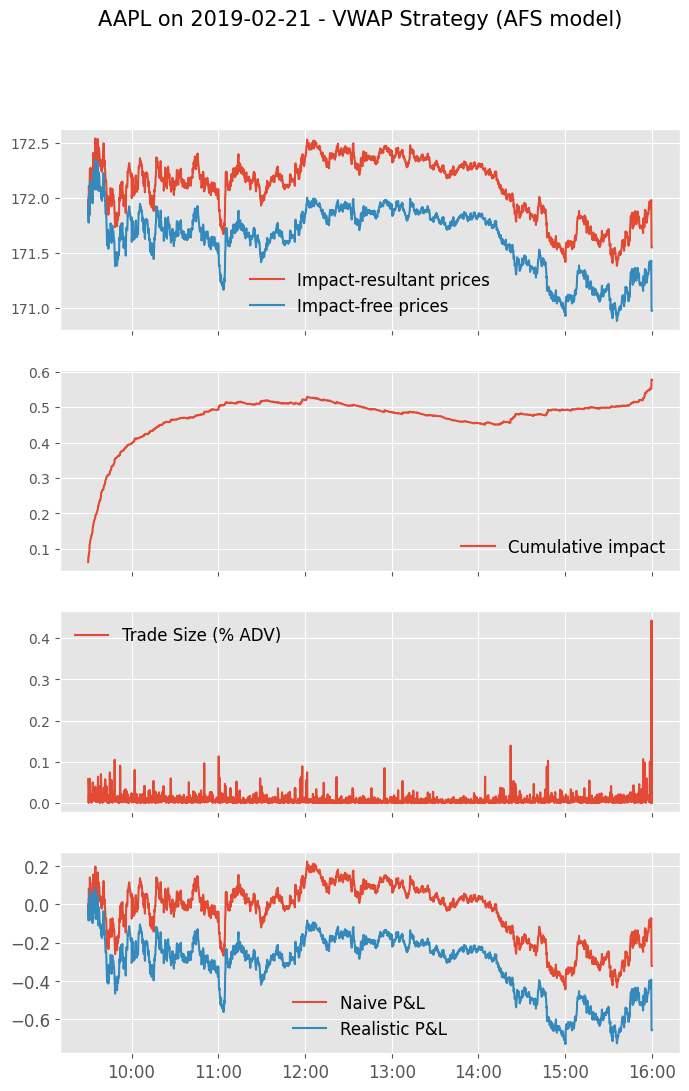

In [39]:
fig, axs = plt.subplots(4, 1, figsize=(8,12), sharex=True)
axs[0].plot(times, vwap_impacted_prices_afs.values, label="Impact-resultant prices")
axs[0].plot(times, adjusted_prices_afs.values, label="Impact-free prices")
axs[0].legend(fontsize=12, frameon=False)
axs[1].plot(times, vwap_impact_afs.values, label="Cumulative impact")
axs[1].legend(fontsize=12, frameon=False)
axs[2].plot(times, vwap_trade_size_pct_afs.values, label="Trade Size (% ADV)")
axs[2].legend(fontsize=12, frameon=False)
axs[3].plot(times, vwap_pnl1_afs.values, label="Naive P&L")
axs[3].plot(times, vwap_pnl2_afs.values, label="Realistic P&L")
axs[3].legend(fontsize=12, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.suptitle(f"{stock} on {date} - VWAP Strategy (AFS model)", fontsize=15)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.show()
